In [9]:
include("../talks/XFZ18.jl")

to_zonotope_flowpipe (generic function with 1 method)

In [10]:
using LazySets, Plots, Plots.PlotMeasures, LaTeXStrings, Reachability

## 0. Experiment with XFZ18 model

In [3]:
using Reachability, MathematicalSystems, LazySets, TaylorIntegration
using Reachability: solve

@taylorize function vanderPol_0!(dx, x, params, t)
    dx[1] = x[2]
    dx[2] = (-0.2*x[1] + x[2]) - (0.2*x[1]^2)*x[2]
    return dx
end

In [5]:
function vanderpol_0(; X0=Hyperrectangle(low=[-0.5, -0.5], high=[0.5, 0.5]),
                        T=4.0,
                        property=(t, x) -> x[2] < 5.0)

    # equations of motion x' = f(x(t))
    F = BlackBoxContinuousSystem(vanderPol_0!, 2)

    # problem options
    𝑂 = Options(:T=>T, :mode=>"check", :property=>property)
    
    # instantiate problem
    𝑃 = InitialValueProblem(F, X0)

    return 𝑃, 𝑂
end

vanderpol_0 (generic function with 1 method)

In [6]:
𝑃, 𝑂 = vanderpol_0(X0=Hyperrectangle(low=[-0.001, -0.001], high=[0.001, 0.001]))
𝑂jets = Options(:abs_tol=>1e-14, :orderT=>6, :orderQ=>2, :max_steps=>500, :output=>:Box)
@time sol = solve(𝑃, 𝑂, op=TMJets(𝑂jets));
# @assert all([ρ([0.0, 1.0], sol.Xk[i].X) < 2.75 for i in eachindex(sol.Xk)])

 23.543339 seconds (47.99 M allocations: 2.331 GiB, 7.86% gc time)


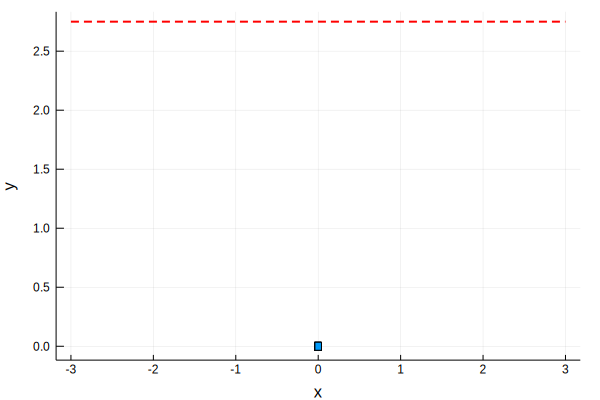

In [7]:
plot(sol, xlab="x", ylab="y")
plot!(x->x, x->2.75, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

In [8]:
# Getting the Taylor Models 

## 1a. Experiments: Van der Pol model using TMJets and $\mu = 1$

In [ ]:
# =================================================================
# Van der Pol model
# See https://easychair.org/publications/paper/gjfh
# =================================================================

using Reachability, MathematicalSystems, LazySets, TaylorIntegration
using Reachability: solve

@taylorize function vanderPol_1a!(dx, x, params, t)
    local μ = 1.0 # 0.25
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

function vanderpol_1a(; X0=Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45]),
                        T=7.0,
                        property=(t, x) -> x[2] < 2.75)

    # equations of motion x' = f(x(t))
    F = BlackBoxContinuousSystem(vanderPol_1a!, 2)

    # problem options
    𝑂 = Options(:T=>T, :mode=>"check", :property=>property)
    
    # instantiate problem
    𝑃 = InitialValueProblem(F, X0)

    return 𝑃, 𝑂
end

### 1a.1 Box overapproximation of the TM flowpipe

In [ ]:
X0def = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45]) # default values for μ = 1.0 in ARCH-COMP

#𝑃, 𝑂 = vanderpol_1a(X0=Hyperrectangle(low=[1.8, 0.8], high=[1.9, 0.9]))
𝑃, 𝑂 = vanderpol_1a(X0=X0def)

𝑂jets = Options(:abs_tol=>1e-10, :orderT=>7, :orderQ=>2, :max_steps=>500, :output=>:Box)

# compute reachable sets
@time sol = solve(𝑃, 𝑂, op=TMJets(𝑂jets));

# verify that specification holds
@assert all([ρ([0.0, 1.0], sol.Xk[i].X) < 2.75 for i in eachindex(sol.Xk)])

In [ ]:
plot(sol, xlab="x", ylab="y")
plot!(x->x, x->2.75, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

### 1a.2 Zonotopic overapproximation of the TM flowpipe

In [ ]:
𝑃, 𝑂 = vanderpol_1a(X0=X0def)
𝑂jets = Options(:abs_tol=>1e-10, :orderT=>7, :orderQ=>2, :max_steps=>500, :output=>:TaylorModel)

# compute reachable sets
@time sol = solve(𝑃, 𝑂, op=TMJets(𝑂jets));
xTM = sol.Xk; # Taylor model flowpipe

In [ ]:
Nmax = size(xTM)[2]
zTM = to_zonotope_flowpipe(xTM, Nmax);

In [ ]:
plot!(zTM, xlab="x", ylab="y")

In [ ]:
plot(zTM)

In [ ]:
# verify that specification holds
@assert all([ρ([0.0, 1.0], zTMi) < 2.75 for zTMi in zTM])

## 1b. Experiments: Van der Pol model using TMJets and $\mu = 2$

In [ ]:
# =================================================================
# Van der Pol model
# See https://easychair.org/publications/paper/gjfh
# =================================================================

using Reachability, MathematicalSystems, LazySets, TaylorIntegration
using Reachability: solve

@taylorize function vanderPol_1b!(dx, x, params, t)
    local μ = 2.0
    dx[1] = x[2]
    dx[2] = (μ * x[2]) * (1 - x[1]^2) - x[1]
    return dx
end

# ----------------------------------------
# Case 2: μ = 2
# ----------------------------------------

function vanderpol_1b(; X0=Hyperrectangle(low=[1.25, 2.35], high=[1.85, 2.45]),
                     T=8.0,
                     property=(t, x) -> x[2] < 4.0)

    # equations of motion x' = f(x(t))
    F = BlackBoxContinuousSystem(vanderPol_1b!, 2)

    # problem options
    𝑂 = Options(:T=>T, :mode=>"check", :property=>property)
    
    # instantiate problem
    𝑃 = InitialValueProblem(F, X0)

    return 𝑃, 𝑂
end

X0_μ2 = Hyperrectangle(low=[1.55, 2.35], high=[1.85, 2.45])

# algorithm-specific options
𝑂jets = Options(:abs_tol=>1e-10, :orderT=>8, :orderQ=>2, :max_steps=>500)

# the idea is to split the initial states along the "x" direction
# n controls the splitting
nsplits_x = 8

function compute_μ2(;n::Int=8, validate=true, output=:Box)
    sol_2 = []
    for X0i in LazySets.split(X0_μ2, [n, 1])
        𝑃, 𝑂 = vanderpol_1b(T=8.0, X0=X0i, property=(t,x) -> x[2] < 4.0)
        𝑂jets = Options(:abs_tol=>1e-10, :orderT=>8, :orderQ=>1, :max_steps=>500, :output=>output)
        sol_2_i = solve(𝑃, 𝑂, op=TMJets(𝑂jets))
        push!(sol_2, sol_2_i)
        if validate
            # verify that specification holds
            @assert all([ρ([0.0, 1.0], sol_2_i.Xk[i].X) < 4.0 for i in eachindex(sol_2_i.Xk)])
        end
    end
    return sol_2
end

### 1b.1 Box overapproximation of the TM flowpipe

In [ ]:
sol_1b = compute_μ2(n=nsplits_x, validate=true, output=:Box);

In [ ]:
plot(sol_1b[1], xlab="x", ylab="y")
plot(sol_1b[2], xlab="x", ylab="y")
plot(sol_1b[3], xlab="x", ylab="y")
plot(sol_1b[4], xlab="x", ylab="y")
plot!(x->x, x->4.0, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

### 1b.2 Zonotopic overapproximation of the TM flowpipe

In [ ]:
xTM_1b = compute_μ2(n=nsplits_x, validate=false, output=:TaylorModel);

In [ ]:
Nmax = [size(xi.Xk)[2] for xi in xTM_1b] # size of each chunk

In [ ]:
zTM = [to_zonotope_flowpipe(xTM_1b[i].Xk, Nmax[i]) for i in eachindex(xTM_1b)];

In [ ]:
plot(zTM[1], xlab="x", ylab="y")
plot(zTM[2], xlab="x", ylab="y")
plot(zTM[3], xlab="x", ylab="y")
plot(zTM[4], xlab="x", ylab="y")
plot!(x->x, x->4.0, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

## Appendix 1: Zonotope flowpipe

In [ ]:
using LazySets
using TaylorModels
using IntervalArithmetic
const IA = IntervalArithmetic

const zeroI = IA.Interval(1.0)
const oneI = IA.Interval(1.0)
const symI = IA.Interval(-1.0, 1.0)
const zeroBox = IntervalBox(zeroI, 2)
const symBox = IntervalBox(symI, 2)

function to_zonotope_flowpipe(xTM, Nmax)
    m = 2 # dimension 2 only
    res = Vector{Zonotope{Float64}}(undef, Nmax)
   
    for i in 1:Nmax
        Xk = xTM[:, i]
        Δt = Xk[1].dom
        Xk_Δt = evaluate(Xk, Δt)
        X̂k = [TaylorModelN(Xk_Δt[k], Xk[k].rem, zeroBox, symBox) for k in 1:m]
        fX̂k = fp_rpa.(X̂k)
        res[i] = overapproximate(fX̂k, Zonotope)
    end
    return res
end

## Appendix 2: additional plots

In [ ]:
plot(sol,
     tickfont=font(15, "Times"), guidefontsize=25,
     xlab=L"x\raisebox{-0.5mm}{\textcolor{white}{.}}",
     ylab=L"y\raisebox{2mm}{\textcolor{white}{.}}",
     xtick=[-3., -2., -1., 0., 1., 2., 3.], ytick=[-3., -2., -1., 0., 1., 2., 3.],
     xlims=(-3., 3.), ylims=(-3., 3.),
     bottom_margin=6mm, left_margin=-2mm, right_margin=4mm, top_margin=3mm,
     size=(600, 600), linecolor="lightblue", color="lightblue")

plot!(x->x, x->2.75, -3., 3., line=2, color="red", linestyle=:dash, legend=nothing)

## Appendix 3: old

In [ ]:
# ====================
# Temp function
# ====================

using LazySets.Approximations
using IntervalArithmetic: IntervalBox
using LazySets: center
using Reachability.ReachSets: validated_integ 

function _solve(𝑃, 𝑂)
    
    # system of ODEs
    f! = 𝑃.s.f
    n = statedim(𝑃)

    # initial time and time horizon
    t0 = 0.0
    T = 𝑂[:T]

    # maximum allowed number of steps
    max_steps = 𝑂[:max_steps]

    # unrap algorithm-specific options
    abs_tol, orderQ, orderT = 𝑂[:abs_tol], 𝑂[:orderQ], 𝑂[:orderT]

    # initial sets
    box_x0 = box_approximation(𝑃.x0)
    q0 = center(box_x0)
    δq0 = IntervalBox(low(box_x0)-q0, high(box_x0)-q0)

    set_variables("x", numvars=length(q0), order=2*orderQ)
    property = 𝑂[:property]
    tTM, xTM, xTM1v = validated_integ(f!, q0, δq0, t0, T, orderQ, orderT, abs_tol,
                                      maxsteps=max_steps, check_property=property)
end

function rsol_hyperrectangle(tTM, xTM, 𝑂)
    # convert to hyperrectangle and wrap around the reach solution
    N = length(xTM)
    Rsets = Vector{ReachSet{Hyperrectangle{Float64}}}(undef, N-1)
    @inbounds for i in 1:N-1
        Hi = convert(Hyperrectangle, xTM[i])
        t0 = tTM[i]; t1 = tTM[i+1]
        Rsets[i] = ReachSet(Hi, t0, t1)
    end

    Rsol = ReachSolution(Rsets, 𝑂)
end

In [ ]:
# benchmark settings
𝑃, 𝑂 = vanderpol()

# algorithm-specific options
𝑂TMJets = Options(:abs_tol=>1e-10, :orderT=>10, :orderQ=>2, :max_steps=>500, :plot_vars=>[1, 2])
merge!(𝑂, 𝑂TMJets)

tTM, xTM, TM = _solve(𝑃, 𝑂);

# convert to hyperrectangle
Rsol_H = rsol_hyperrectangle(tTM, xTM, 𝑂);

In [ ]:
TM1 = TM[:, 1]

In [ ]:
TM[:, 2][1]

In [ ]:
overapproximate(TM1, Zonotope)

In [ ]:
S1 = evaluate(TM1, TM1[1].dom)

In [ ]:
# convert to a vector TaylorModelN
S1[1]

In [ ]:
o = S1[1]

In [ ]:
typeof(S1[1])

In [ ]:
overapproximate(S1, Zonotope)

In [ ]:
TM2 = TM[:, 2];
TM2[1]

In [ ]:
TM2[1].dom # == TM2[2].dom (must be the same for the components)

In [ ]:
TM2[1].rem

In [ ]:
TM[:, 6][1].dom

In [ ]:
plot(Rsol_H, xlab="x1", ylab="x2")

In [ ]:
typeof(TM)

In [ ]:
p1 = TM[1]

In [ ]:
typeof(p1)